# Code for competition

Libraries imports and initializations

In [1]:
import tensorflow as tf
import numpy as np
import os, os.path
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import visualkeras

tfk = tf.keras
tfkl = tf.keras.layers
print(f"Tensorflow version = ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Tensorflow version =  2.6.0
Num GPUs Available:  1


Load the dataset

In [2]:
samples = []
targets = []

images_ind = [186, 532, 515, 511, 531, 222, 537, 508]

# for each species
for i in range(0, len(images_ind)):
    # for each image in every species folder
    for j in range(0, images_ind[i]):
        temp = Image.open(f'training_data_final/Species{i + 1}/{j:05}.jpg').convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0))
        label = tfk.utils.to_categorical(i, len(images_ind))
        samples.append(image)
        targets.append(label)

# creation of augmented dataset 
X = np.array(samples)
y = np.array(targets)
print(X.shape, y.shape)


(3542, 96, 96, 3) (3542, 8)


Models metadata

In [3]:
input_shape = X.shape[1:]
image_shape = input_shape[:-1]

batch_size = 64 # TODO: try with other batch sizes and check the difference in accuracy and GPU utilization
epochs = 400
labels = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]

### Static augmentation

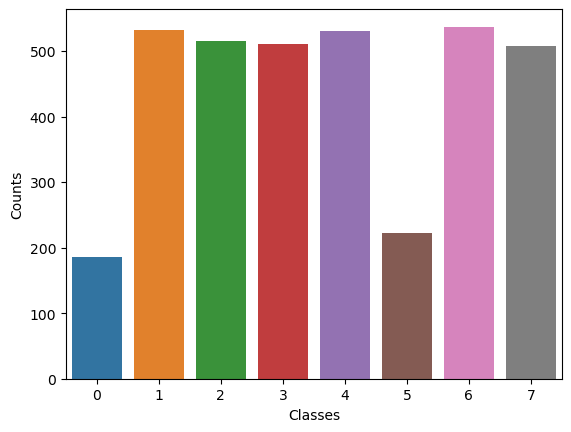

In [4]:
classes, counts = np.unique(np.fromiter([np.argmax(t) for t in y], np.int32), return_counts=True)

#shows classes imbalance
plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

In [5]:
# image transformations generator
gen = ImageDataGenerator(rotation_range = 90, # increased rotation range to 90 degrees
                         height_shift_range = 20,
                         width_shift_range = 20,
                         horizontal_flip = True,
                         vertical_flip = True,
                         zoom_range = 0.2, # added zoom range
                         fill_mode = 'reflect')

# number of images to reach for each category
desired_amount = 800

ref_list = []
aug_samples = []
aug_targets = []

for i in range(0, len(classes)):
    ref_list.append([])
  
for i in range(0, len(y)):
    ref_list[np.argmax(y[i])].append(X[i])

for i in range(0, len(classes)):
    length = len(ref_list[i])
    to_produce = desired_amount - length
    target = tfk.utils.to_categorical(i, len(classes))
    print(f'Computing {to_produce} augmented images for target {i}')

    # produces images and corresponding targets
    aug_targets_i = np.full((length, len(classes)), target)
    aug_gen_i = gen.flow(np.array(ref_list[i]), 
                         aug_targets_i,
                         batch_size=1,
                         seed=seed,
                         shuffle=True)

    # augmented data samples
    for j in range(0, to_produce):
        aug_samples.append(np.squeeze(next(aug_gen_i)[0]))
        aug_targets.append(target)

# augmented dataset
X_aug = np.concatenate((X, np.array(aug_samples)))
y_aug = np.concatenate((y, np.array(aug_targets)))
print(X_aug.shape, y_aug.shape)

Computing 614 augmented images for target 0
Computing 268 augmented images for target 1
Computing 285 augmented images for target 2
Computing 289 augmented images for target 3
Computing 269 augmented images for target 4
Computing 578 augmented images for target 5
Computing 263 augmented images for target 6
Computing 292 augmented images for target 7
(6400, 96, 96, 3) (6400, 8)


Showing a few examples of augmented images, one image per class

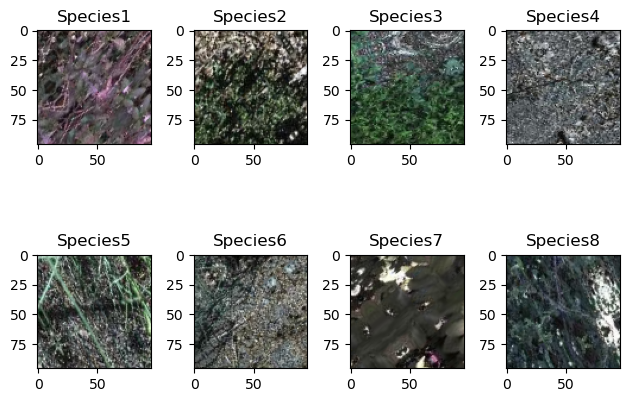

In [6]:
num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col)
for i in range(num_row * num_col):

    # show a random augmented image
    # TODO: not working because it does not choose an image from each class correctly
    img = Image.fromarray(np.uint8(random.choice(aug_samples)))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(img)
    ax.set_title(labels[i])

plt.tight_layout()
plt.show()

Dataset balanced and shuffled

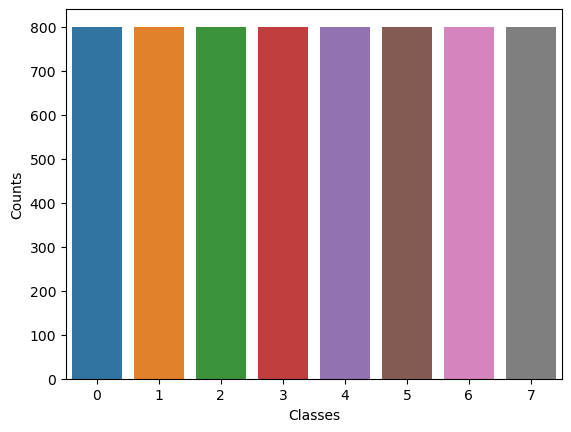

In [7]:
# counts of the number of samples per each class, before balancement
classes, counts = np.unique(np.fromiter([np.argmax(t) for t in y_aug], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

# probably not needed, wrote this just in case
X_aug, y_aug = shuffle(X_aug, y_aug)

### Models definition

Convolutional model defined as a stack of some convolution layers, max pooling, gap and dropout layers.

Fully connected dense layers stacked after the convolutional layers, with no regularization applied. 5 layers of 128 neurons each

In [8]:
def build_conv_dense_model(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv1')(input_layer)
    
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv2')(x)
    
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'Conv3')(x)
    
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    
    #x = tfkl.Dropout(0.2, seed=seed, name='gap_dropout')(x)

    # end of convolutional layers
    # start of the fully connected layers
    
    x = tfkl.Flatten()(x)
    
    x = tfkl.Dense(
        units = 512,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense1')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense2')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense3')(x)

    x = tfkl.Dense(
        units = 128,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense4')(x)

    x = tfkl.Dense(
        units = 128,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense5')(x)
    
    x = tfkl.Dropout(0.2, seed=seed, name='dropout')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'conv_dense_model_v1')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model



# First attempt: Hold Out validation


Split the dataset (85-15)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_aug, y_aug, stratify=y_aug, test_size=0.15)

print(f"training set input shape", X_train.shape, y_train.shape)
print(f"validation set input shape",X_val.shape, y_val.shape)


training set input shape (5440, 96, 96, 3) (5440, 8)
validation set input shape (960, 96, 96, 3) (960, 8)


Train the model

In [10]:
# first convolutional model
model = build_conv_dense_model(input_shape)

model.summary()

#visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

Model: "conv_dense_model_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 96, 256)       7168      
_________________________________________________________________
mp1 (MaxPooling2D)           (None, 48, 48, 256)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 48, 256)       590080    
_________________________________________________________________
mp2 (MaxPooling2D)           (None, 24, 24, 256)       0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 24, 24, 256)       590080    
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 256)       

In [ ]:
# training
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

### Plot training results

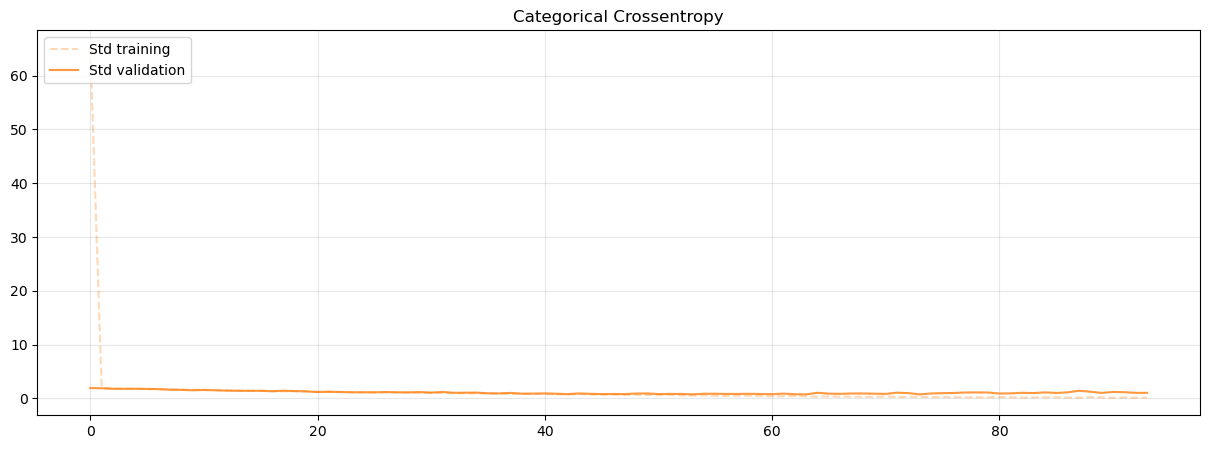

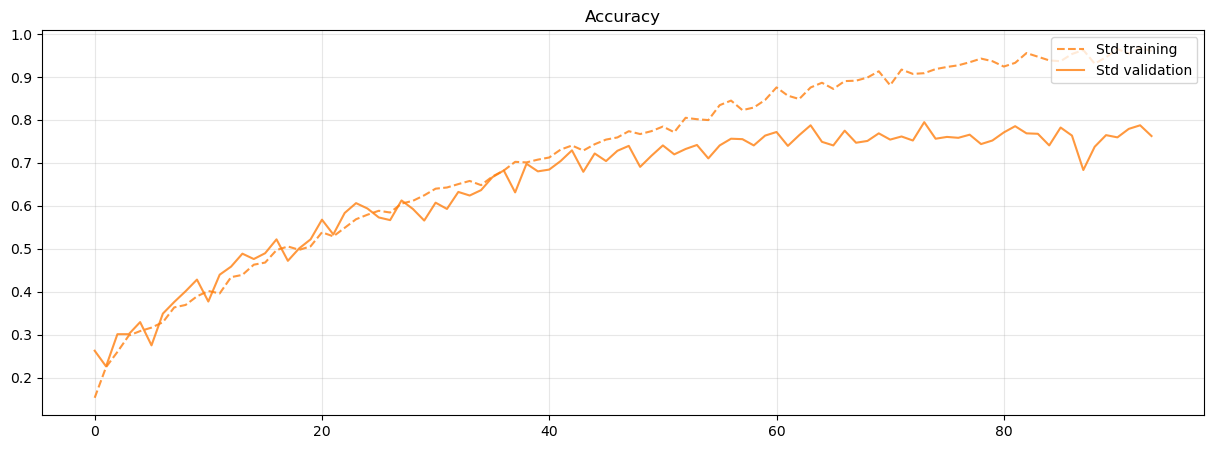

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

Plot the confusion matrix (evaluated on the validation set)

Accuracy: 0.7948
Precision: 0.8046
Recall: 0.7948
F1: 0.7959


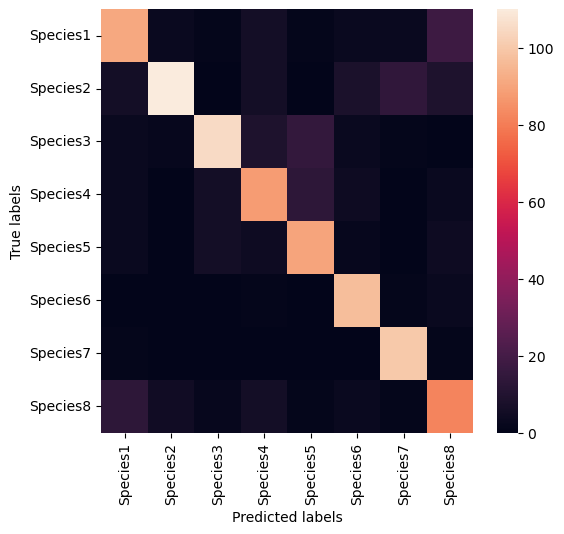

In [ ]:
predictions = model.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(6,5.5))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

Plot one example of an image for each class from the validation set of images.
For each image show the prediction on a bar plot

In [ ]:
#TODO: fix this code
example_prediction = random.choice(X_val[0])
'''
fig, axes = plt.subplots(8,2)
fig.set_size_inches(10,20)
for i in range(8):

	# TODO: find random choice from validation set, one per class

	axes[i, 0].imshow(X_val[choice])
	axes[i, 0].set_title('True label: ' + labels[np.argmax(y_val[choice])])
	axes[i, 1].barh(list(labels.values()), predictions[prediction_index], color=plt.get_cmap('Paired').colors)
	axes[i, 1].set_title('Predicted label: '+labels[np.argmax(predictions[prediction_index])])
	axes[i, 1].grid(alpha=.3)


plt.show()
'''

### Save the model

Here it is not working

In [ ]:
restored_model = tfk.models.load_model('simo_model')

#TODO: not right because validation set can change
restored_loss, restored_acc = restored_model.evaluate(X_val, y_val, verbose=2)
loss, acc = model.evaluate(X_val, y_val, verbose=2)
if acc > restored_acc:  # know that this is conceptually wrong
    print("Model improved!")
    model.save('simo_model')
else:
    print("No improvement!")

30/30 - 1s - loss: 0.7283 - accuracy: 0.7948
30/30 - 1s - loss: 0.7283 - accuracy: 0.7948
No improvement!
